Program for testing and generating a dataset, and training an interpolator for the given dataset. Steps:
1. Find the optimal range values for each parameter, taking into account pressures and volumes.
2. Save the parameters and the ved, ves
3. Create, train and test an interpolator ('net') for predicting ved, ves in the whole chosen space.
4. Check the ved, ves values and pressures along all the dataset.
Next, the adjoint odeint method and the NN-interpolator method are tested and compared in two tasks:
1. They are trained on a fixed synthetic input with the goal of finding optimal parameters yielding the true labels,
2. They are trained on a synthetic dataset of 400 patients with the goal of finding optimal parameters yielding correct labels for the patients. They are next tested on a set of 50 synthetic patients.

Using 3 inputs and 3 label times, only code to modify is function f at beginning (for ini conds), def syst_ode, and codebox in "This is the only code to modify:"

1. Finding optimal ranges:

In [1]:
import numpy as np
import torch
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import os
from skimage.transform import rescale, resize
import torch.nn.functional as F
from torch.utils.data import Subset
import itertools
from math import prod

import time
from scipy.integrate import odeint #collection of advanced numerical algorithms to solve initial-value problems of ordinary differential equations.
from matplotlib import pyplot as plt
import random
import sys

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Define the cardiac ODE system (f has to be changed based on the parameters are fixed, which have to be defined inside of f in order to simplify the rest of the program)

In [2]:
def syst_ode(y, t, a, b, c):
    x1, x2 = y
    dydt = [ 0.001 * a * x1 - t * a + b*x2 + min(x2*a*0.001 - 0.2, 0), t**2 * b + t*a*0.1 - b*a * x1 + x2 * 0.001]
    return dydt

def f(a, b, c, plotcurves, t1, t2, t3):
    y0 = [c * 2. - 1., c * 0.5]

    t = np.linspace(0., 1., 1000) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
    #changed to 60000 for having integer positions for Tmax

    sol = odeint(syst_ode, y0, t, args = (a, b, c)) #t: list of values

    result0 = np.array(sol[:, 0])
    result1 = np.array(sol[:, 1])

    if plotcurves:
      plt.plot(t, result0, color='red')
      plt.xlabel("t")
      plt.ylabel("y0")
      #plt.show()
      plt.plot(t, result1)
      plt.xlabel("t")
      plt.ylabel("y1")
      #plt.show()

    return result0[int(t1*1000)], result0[int(t2*1000)], result0[int(t3*1000)]

Do some testing by varying the intervals, the number of parameters and the number of points:

This is the only code to modify:

In [3]:
ints = [[-2., 2.], [-2., 2.], [-3., 3.]] #validity interval for each learnable parameter
nvals_pars_test = [4, 4, 4] #number of values taken from each parameter
nvals_pars = [30, 30, 30] #number of values taken from each parameter for creating the dataset
t1, t2, t3 = 0.3, 0.5, 0.95

(-2.0, -2.0, -3.0) (2.0, 2.0, 3.0)
0 / 64


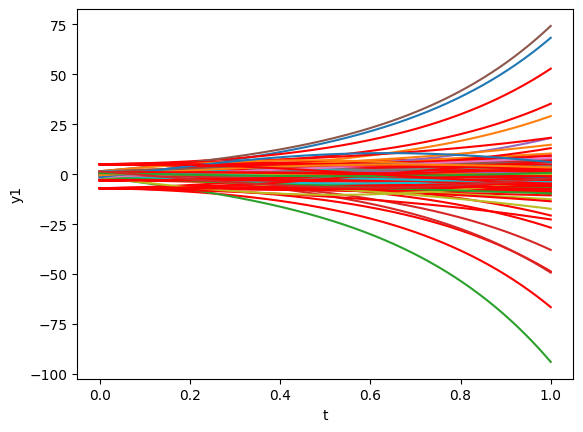

In [4]:
n_pars = len(ints)
n_points = prod(nvals_pars_test)

pars = []
for i in range(n_pars):
  pars.append(np.linspace(ints[i][0], ints[i][1], nvals_pars_test[i]))

points = list(itertools.product(*pars))
print(points[0], points[-1])

labels1 = []
labels2 = []
labels3 = []
i=0

for point in points:
  l1, l2, l3 = f(*point, True, t1, t2, t3) ##recommended to plot the pv loops when building the intervals
  labels1.append(l1)
  labels2.append(l2)
  labels3.append(l3)

  if i%100==0: print(i, "/", n_points)
  i+=1
plt.show()

Once all the parameters are found, generate and save enough sample points for the interpolation:

In [5]:
## rewrite here the definitive intervals, number of parameters and Vd points for the generation of the dataset:
n_pars = len(ints)
n_points = prod(nvals_pars)

pars = []
for i in range(n_pars):
  pars.append(np.linspace(ints[i][0], ints[i][1], nvals_pars[i]))

points = list(itertools.product(*pars))

In [6]:
labels1 = []
labels2 = []
labels3 = []
i=0

for point in points:
  l1, l2, l3 = f(*point, False, t1, t2, t3) ##recommended to plot the pv loops when building the intervals
  labels1.append(l1)
  labels2.append(l2)
  labels3.append(l3)

  if i%100==0: print(i, "/", n_points)
  i+=1

#convert into torch tensors:
points2 = torch.tensor(points)
tensor1 = torch.tensor(labels1)
tensor2 = torch.tensor(labels2)
tensor3 = torch.tensor(labels3)
tensor123 = torch.stack((tensor1, tensor2, tensor3), dim=1)

'''
#save points and ved, ves:
output_path = '/content/drive/My Drive/'
file = 'pts_tensor'
torch.save(points2, os.path.join(output_path,f'{file}.pt'))
file = 'tensor123'
torch.save(tensor123, os.path.join(output_path,f'{file}.pt'))
print("Saved")
'''

0 / 27000
100 / 27000
200 / 27000
300 / 27000
400 / 27000
500 / 27000
600 / 27000
700 / 27000
800 / 27000
900 / 27000
1000 / 27000
1100 / 27000
1200 / 27000
1300 / 27000
1400 / 27000
1500 / 27000
1600 / 27000
1700 / 27000
1800 / 27000
1900 / 27000
2000 / 27000
2100 / 27000
2200 / 27000
2300 / 27000
2400 / 27000
2500 / 27000
2600 / 27000
2700 / 27000
2800 / 27000
2900 / 27000
3000 / 27000
3100 / 27000
3200 / 27000
3300 / 27000
3400 / 27000
3500 / 27000
3600 / 27000
3700 / 27000
3800 / 27000
3900 / 27000
4000 / 27000
4100 / 27000
4200 / 27000
4300 / 27000
4400 / 27000
4500 / 27000
4600 / 27000
4700 / 27000
4800 / 27000
4900 / 27000
5000 / 27000
5100 / 27000
5200 / 27000
5300 / 27000
5400 / 27000
5500 / 27000
5600 / 27000
5700 / 27000
5800 / 27000
5900 / 27000
6000 / 27000
6100 / 27000
6200 / 27000
6300 / 27000
6400 / 27000
6500 / 27000
6600 / 27000
6700 / 27000
6800 / 27000
6900 / 27000
7000 / 27000
7100 / 27000
7200 / 27000
7300 / 27000
7400 / 27000
7500 / 27000
7600 / 27000
7700 / 2700

'\n#save points and ved, ves:\noutput_path = \'/content/drive/My Drive/\'\nfile = \'pts_tensor\'\ntorch.save(points2, os.path.join(output_path,f\'{file}.pt\'))\nfile = \'tensor123\'\ntorch.save(tensor123, os.path.join(output_path,f\'{file}.pt\'))\nprint("Saved")\n'

Once the points and pairs (ved, ves) saved, create and train the interpolator:

In [7]:
'''
##in case it is a new session, get the data from the drive:

output_path = '/content/drive/My Drive/'
file = 'points.pt'
pts = torch.load(output_path + file)
print("First and last point:", pts[0], pts[-1]) ##check if all points had been saved
file = 'vedves.pt'
# Load the data points from the file
vedves = torch.load(output_path + file)
x = torch.tensor(pts, dtype = torch.float64)
y = torch.tensor(vedves, dtype=torch.float64)
'''

'\n##in case it is a new session, get the data from the drive:\n\noutput_path = \'/content/drive/My Drive/\'\nfile = \'points.pt\'\npts = torch.load(output_path + file)\nprint("First and last point:", pts[0], pts[-1]) ##check if all points had been saved\nfile = \'vedves.pt\'\n# Load the data points from the file\nvedves = torch.load(output_path + file)\nx = torch.tensor(pts, dtype = torch.float64)\ny = torch.tensor(vedves, dtype=torch.float64)\n'

In [8]:
pts = points2
x = torch.tensor(pts, dtype = torch.float64)
y = torch.tensor(tensor123, dtype=torch.float64)

<ipython-input-8-7d8d39fd7a45>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(pts, dtype = torch.float64)
<ipython-input-8-7d8d39fd7a45>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(tensor123, dtype=torch.float64)


Then, create and train the NN-interpolator:

In [9]:
n_pars = len(pts[0])
n_neurons = 256 ##in general 256 is enough
lr = 0.01
threshold_train = 0.0001
threshold_test = 0.01
n_epochs = 30000
n_labels = n_pars

class Interpolator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_pars, n_neurons).double()
        self.fc2 = nn.Linear(n_neurons, n_labels).double()

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = self.fc2(z)
        return z

# Initialize the neural network
net = Interpolator()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
losses = []
i = 0

while True:
  for epoch in range(n_epochs):
      # Forward pass
      y_pred = net(x)
      loss = criterion(y_pred, y)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print progress
      if epoch % 100 == 0:
          print(f'Epoch {epoch}, loss: {loss.item():.4f}')
          losses.append(loss.item())

  if abs(losses[-1] - losses[-2])<5.:
    lr = lr / 10.
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  if (i>10 and losses>50.):
    n_neurons += 24
    net = Interpolator()
  if (i>30): break
  if (losses[-1]<threshold_train): break
  i += 1

print("Training error", loss.item())

Epoch 0, loss: 22.2742
Epoch 100, loss: 1.2272
Epoch 200, loss: 0.4221
Epoch 300, loss: 0.2279
Epoch 400, loss: 0.1473
Epoch 500, loss: 0.1031
Epoch 600, loss: 0.0766
Epoch 700, loss: 0.0598
Epoch 800, loss: 0.0502
Epoch 900, loss: 0.0395
Epoch 1000, loss: 0.0342
Epoch 1100, loss: 0.0288
Epoch 1200, loss: 0.0261
Epoch 1300, loss: 0.0223
Epoch 1400, loss: 0.0204
Epoch 1500, loss: 0.0182
Epoch 1600, loss: 0.1107
Epoch 1700, loss: 0.0156
Epoch 1800, loss: 0.0146
Epoch 1900, loss: 0.0137
Epoch 2000, loss: 0.0134
Epoch 2100, loss: 0.0122
Epoch 2200, loss: 0.0119
Epoch 2300, loss: 0.0111
Epoch 2400, loss: 0.0113
Epoch 2500, loss: 0.0334
Epoch 2600, loss: 0.0106
Epoch 2700, loss: 0.0315
Epoch 2800, loss: 0.0091
Epoch 2900, loss: 0.0088
Epoch 3000, loss: 0.0089
Epoch 3100, loss: 0.0091
Epoch 3200, loss: 0.0081
Epoch 3300, loss: 0.0079
Epoch 3400, loss: 0.0079
Epoch 3500, loss: 0.0075
Epoch 3600, loss: 0.0074
Epoch 3700, loss: 0.0071
Epoch 3800, loss: 0.0439
Epoch 3900, loss: 0.0068
Epoch 4000,

KeyboardInterrupt: 

In [10]:
while True:
  for epoch in range(n_epochs):
      # Forward pass
      y_pred = net(x)
      loss = criterion(y_pred, y)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print progress
      if epoch % 50 == 0:
          print(f'Epoch {epoch}, loss: {loss.item():.4f}')
          losses.append(loss.item())

  if abs(losses[-1] - losses[-2])<5.:
    lr = lr / 10.
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  if (i>10 and losses>50.):
    n_neurons += 24
    net = Interpolator()
  if (i>30): break
  if (losses[-1]<threshold_train): break
  i += 1

print("Training error", loss.item())

Epoch 0, loss: 0.0011
Epoch 50, loss: 0.0012
Epoch 100, loss: 0.0010
Epoch 150, loss: 0.0010
Epoch 200, loss: 0.0083
Epoch 250, loss: 0.0011
Epoch 300, loss: 0.0010


KeyboardInterrupt: 

Once training is finished, test it:

-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-0.1011, -1.9013,  0.9161])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-1.2984,  1.8424, -2.6565])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([ 0.2226,  0.4709, -2.7808])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-1.9492, -0.2288, -0.5223])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([ 0.8352, -0.2456, -0.1304])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-0.2402,  0.3837,  0.6483])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-1.9674,  0.2261, -0.6638])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-1.0401,  1.8327,  1.8272])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([0.8013, 1.0851, 0.6775])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-1.9636, -0.7151, -2.7158])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-0.4128, -1.3739,  1.1505])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-1.3984,  1.1769, -2.0016])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-0.0744, -0.8475, -2.8236])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-0.5787,  0.8679, -2.6848])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([-1.9475,  1.4527,  0.0576])
-2.0 2.0
-2.0 2.0
-3.0 3.0
tensor([ 1.4850, -1.3771, -1.59

<ipython-input-11-3b5226e731c0>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xt = torch.tensor(x_test_tc, dtype = torch.float64)
<ipython-input-11-3b5226e731c0>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yt = torch.tensor(y_test_tc, dtype=torch.float64)


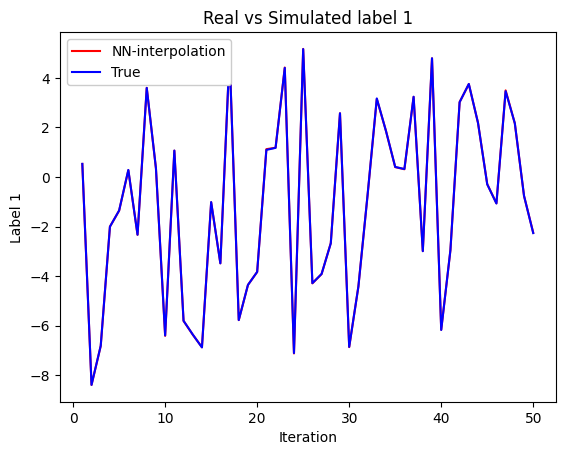

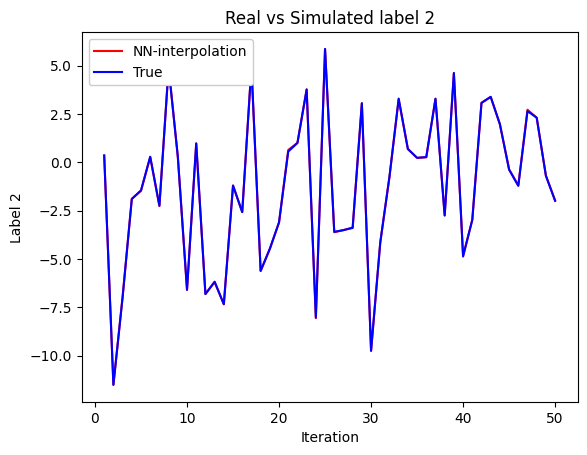

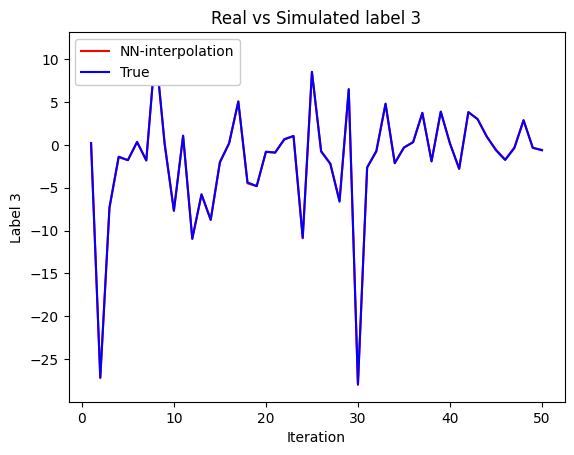

In [11]:
#for testing the interpolator:
n_test = 50
x_test_tc = torch.zeros(n_test, n_pars)
y_test_tc = torch.zeros(n_test, n_labels)

for i in range(n_test):
  for j in range(n_pars):
    print(ints[j][0], ints[j][1])
    x_test_tc[i][j] = random.uniform(ints[j][0], ints[j][1])
  print(x_test_tc[i])
  l1, l2, l3 = f(*(x_test_tc[i].tolist()), False, t1, t2, t3)
  y_test_tc[i][0] = l1
  y_test_tc[i][1] = l2
  y_test_tc[i][2] = l3

error = 0

xt = torch.tensor(x_test_tc, dtype = torch.float64)
yt = torch.tensor(y_test_tc, dtype=torch.float64)

iters=np.linspace(1, n_test, n_test)
#of the tests (given by the real function f):
l1t = []
l2t = []
l3t = []
#simulated by net:
siml1=[]
siml2=[]
siml3=[]

for i in range(n_test):
  y_pred = net(xt[i])
  l1 = y_pred[0].detach().item()
  l2 = y_pred[1].detach().item()
  l3 = y_pred[2].detach().item()

  l1t.append(y_test_tc[i][0])
  l2t.append(y_test_tc[i][1])
  l3t.append(y_test_tc[i][2])

  error += abs(l1 - yt[i][0]) + abs(l2 - yt[i][1]) + abs(l3 - yt[i][2])
  siml1.append(l1)
  siml2.append(l2)
  siml3.append(l3)

print("Average test error:", error / (n_test*3))

'''
#save the weights of net if it works well enough:
if (error/(n_test*2)<threshold_test):
  import os
  output_path = '/content/drive/My Drive/'
  file = 'net_weights2'
  torch.save(net.state_dict(), os.path.join(output_path,f'{file}__weight.pt'))
  print("Weights saved")
'''

#plot the results: (real vs estimated ved, ves, ef. real: blue, simulated by the net: red)
plt.title("Real vs Simulated label 1")
plt.plot(iters, siml1, color='r', label='NN-interpolation')
plt.plot(iters, l1t, color='b', label='True')
plt.ylabel("Label 1")
plt.xlabel("Iteration")
plt.legend(loc='upper left', framealpha=1)
plt.show()
plt.title("Real vs Simulated label 2")
plt.plot(iters,siml2, color='r', label='NN-interpolation')
plt.plot(iters, l2t, color='b', label='True')
plt.ylabel("Label 2")
plt.xlabel("Iteration")
plt.legend(loc='upper left', framealpha=1)
plt.show()
plt.title("Real vs Simulated label 3")
plt.plot(iters,siml3, color='r', label='NN-interpolation')
plt.plot(iters, l3t, color='b', label='True')
plt.ylabel("Label 3")
plt.xlabel("Iteration")
plt.legend(loc='upper left', framealpha=1)
plt.show()

Now 'net' is the NN-interpolator; takes 3 inputs (a,b,c) and returns the 3 labels (error \sim0.04).

Now make neuralode-based model and NN-interpolator model

In [12]:
!pip3 install torchdiffeq

import os
import argparse
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

parser = argparse.ArgumentParser('ODE demo')

parser.add_argument('--method', type=str, choices=['dopri5', 'adams'], default='dopri5')
parser.add_argument('--data_size', type=int, default=1000) #size of true_y and pred_y and t (n of timepoints for the diff eq in odeint)
parser.add_argument('--batch_time', type=int, default=10) #batch_t takes the first batch_time(=10) first elements of t
parser.add_argument('--batch_size', type=int, default=1)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--test_freq', type=int, default=20)
parser.add_argument('--viz', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
args = parser.parse_args(args=[])

from torchdiffeq import odeint_adjoint as odeint_adjoint
from scipy.integrate import odeint as odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [13]:
def get_input_and_l(a, b, c, t1, t2, t3):
    y0 = [c * 2. - 1., c * 0.5]
    t = np.linspace(0., 1., 1000) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
    #changed to 60000 for having integer positions for Tmax
    sol = odeint(syst_ode, y0, t, args = (a, b, c)) #t: list of values
    result0 = np.array(sol[:, 0])
    result1 = np.array(sol[:, 1])
    return [result1[350], result0[650], result0[840], result1[750]], result0[int(t1*1000)], result0[int(t2*1000)], result0[int(t3*1000)]


In [14]:
"""Define Neural ODE-based model:"""

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

## normalizes the parameters to realistic ranges (intervals of validity: same as those used for creating the NN-interpolator)
class Normalizer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([ints[0][0], ints[1][0], ints[2][0]], dtype=torch.float32)
        self.upper = torch.tensor([ints[0][1], ints[1][1], ints[2][1]], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class ODEFunc(nn.Module): #takes y, t and returns dydt = NN(y,t). NN: defined in self.net (NN: (y**3, t**3):2D->50->tanh->2D=dydt)
    def __init__(self, a, b, c):
        super(ODEFunc, self).__init__()
        self.a = a
        self.b = b
        self.c = c

    def forward(self, t, y):
        dydt = torch.zeros_like(y)
        dydt[0] = 0.001 * self.a * y[0] - t * self.a + self.b*y[1] + min(y[1]*self.a*0.001 - 0.2, 0)
        dydt[1] = t**2 * self.b + t*self.a*0.1 - self.b*self.a * y[0] + y[1] * 0.001
        return dydt

class NeuralODE(nn.Module):
    def __init__(self):
        super(NeuralODE, self).__init__()
        ## equivalent to transformations into the transformations video->tensor with the 7 parameters
        self.fc1 = nn.Linear(4, 64).double()
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, n_pars).double()
        self.norm1 = Normalizer()

    def forward(self, x):

        ## next two lines would be the transformation 3DCNN: video -> 7 parameters; pars = the 7 parameters normalized
        pars = self.norm1(self.fc2(self.relu(self.fc1(x))))

        y0 = torch.stack([pars[2] * 2. + torch.tensor(-1.), pars[2] * 0.5], dim=0)

        func = ODEFunc(pars[0], pars[1], pars[2])

        time_interval = torch.tensor([0., t1, t2, t3])
        options = {'step_size': 0.0001}
        pred_y = odeint_adjoint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6, options=options) #method='dopri5'
        l1est = pred_y[1, 0]
        l2est = pred_y[2, 0]
        l3est = pred_y[3, 0]
        #with torch.no_grad(): print(pars, "a", l1est, l2est, l3est)
        '''
        with torch.no_grad(): time_interval = torch.linspace(0, 1., 1000) #spaced numbers over interval (start, stop, number_of_steps), 60000 time instances for each heart cycle
        #changed to 60000 for having integer positions for Tmax
        pred_y = odeint_adjoint(func, y0, time_interval, method='euler', atol=1e-6, rtol=1e-6, options=options) #method='dopri5'
        ved = pred_y[(N-1)*60000, 0] + pars[6]
        ves = pred_y[200*int(60/pars[0])+9000+(N-1)*60000, 0] + pars[6]
        '''

        return l1est, l2est, l3est


In [15]:
ii = 0
model = NeuralODE()
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)

Create fixed input and labels:

In [16]:
# get fixed input and fixed label:
a0, b0, c0 = random.uniform(ints[0][0], ints[0][1]), random.uniform(ints[1][0], ints[1][1]), random.uniform(ints[2][0], ints[2][1])
X, l1, l2, l3 = get_input_and_l(a0, b0, c0, t1, t2, t3)
print(a0, b0, c0)
print(l1, l2, l3)
input = torch.tensor([X[0], X[1], X[2], X[3]])
tl1, tl2, tl3 = torch.tensor(l1), torch.tensor(l2), torch.tensor(l3)
#print(f(a0, b0, c0, False, 0.3, 0.5, 0.95))

-0.2937831537883455 -1.7707895376748728 -0.4613453222825501
-1.9237393398123586 -1.9849892687553523 -2.1833891096440383


Iter 0000 | Total Loss 0.812854


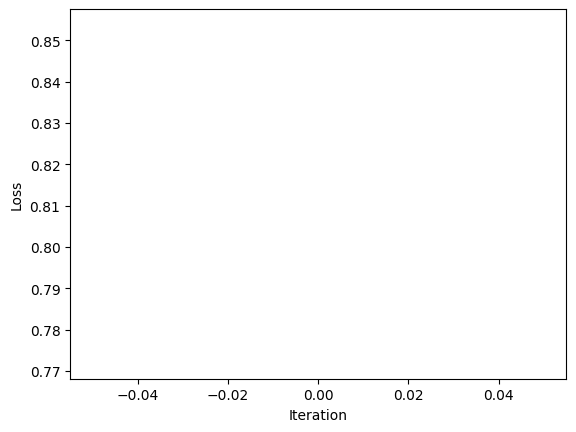

Iter 0005 | Total Loss 0.461951


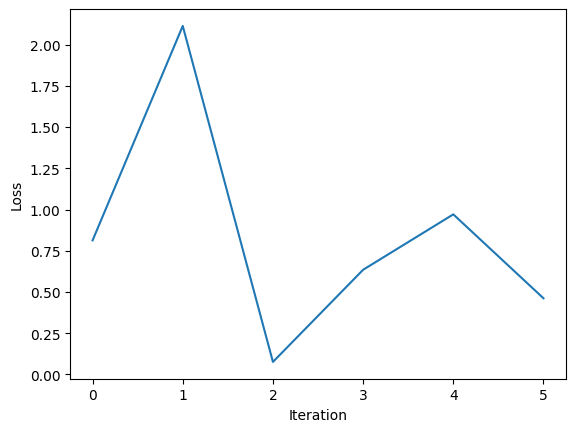

Iter 0010 | Total Loss 0.607602


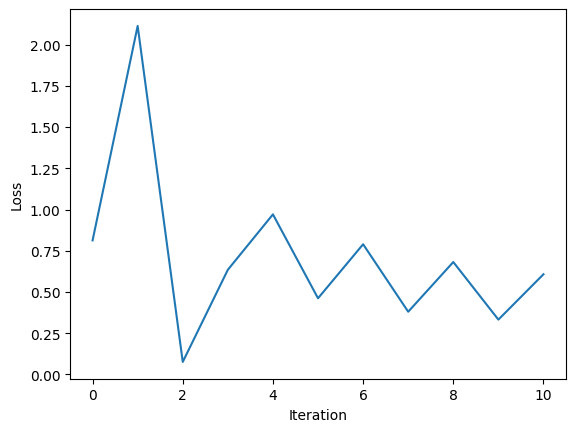

Iter 0015 | Total Loss 0.262914


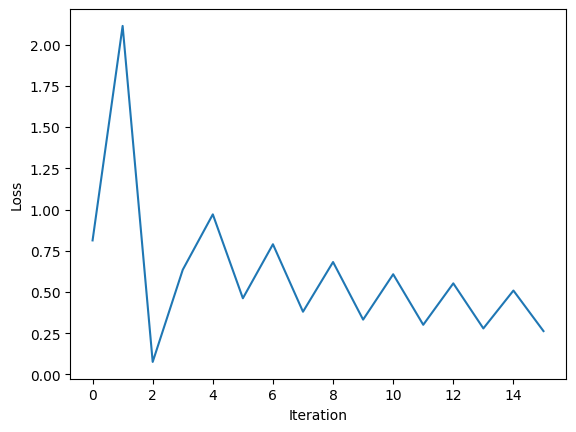

Iter 0020 | Total Loss 0.417925


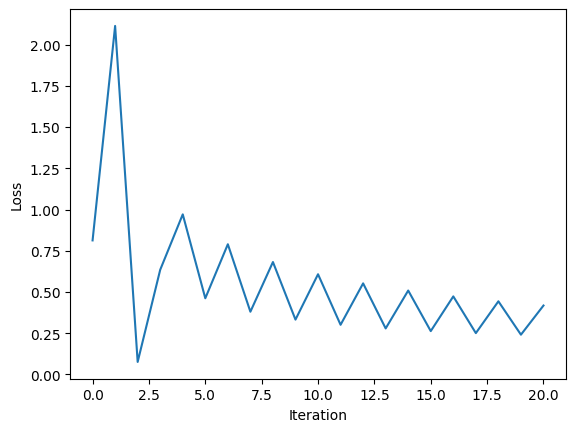

Iter 0025 | Total Loss 0.222975


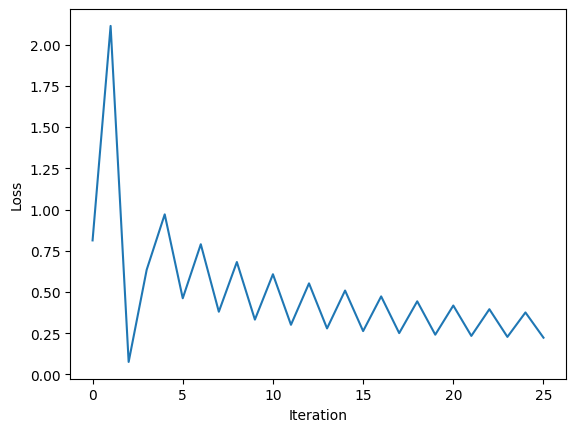

Iter 0030 | Total Loss 0.327910


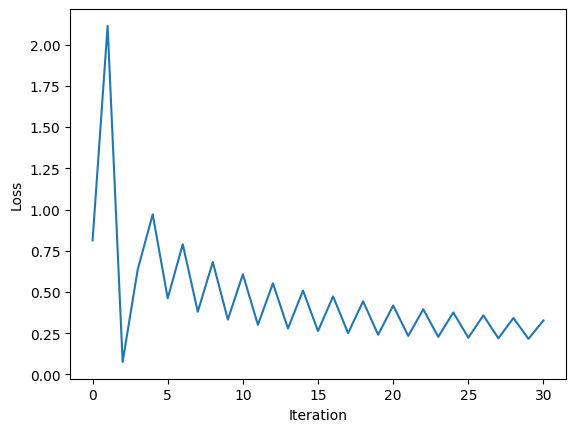

Iter 0035 | Total Loss 0.209921


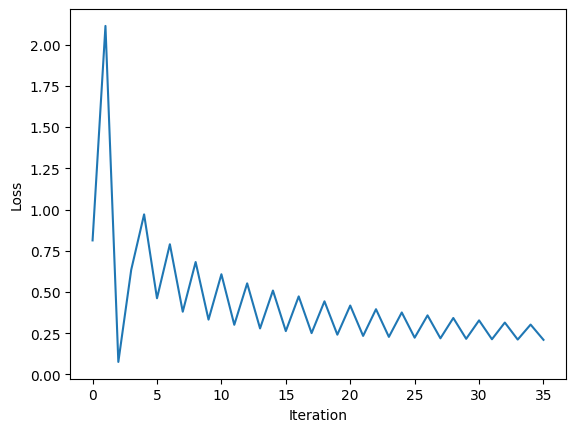

Iter 0040 | Total Loss 0.270702


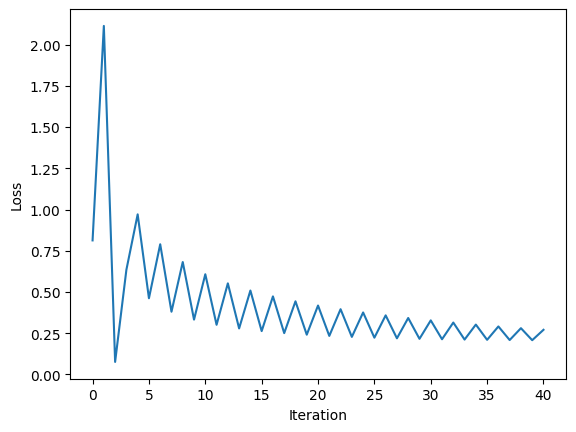

Iter 0045 | Total Loss 0.206270


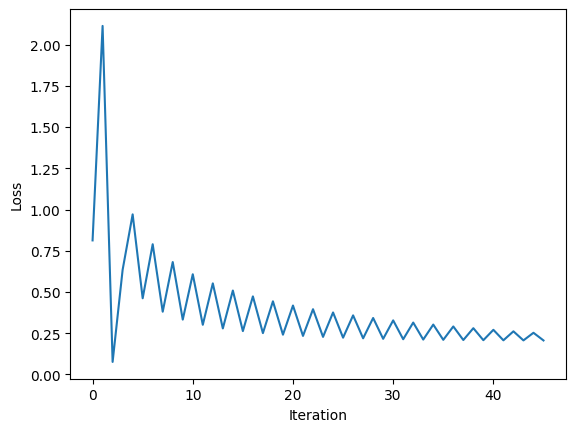

Iter 0050 | Total Loss 0.229278


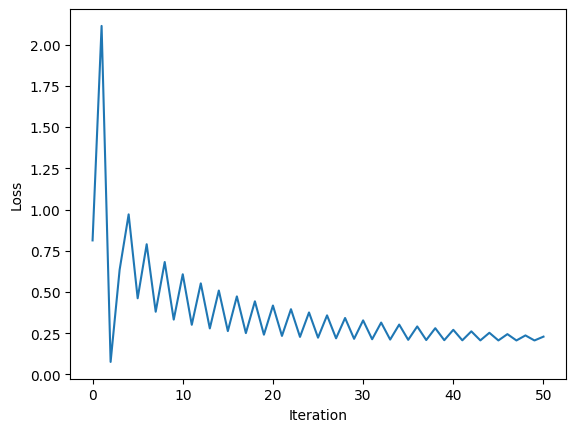

Iter 0055 | Total Loss 0.206919


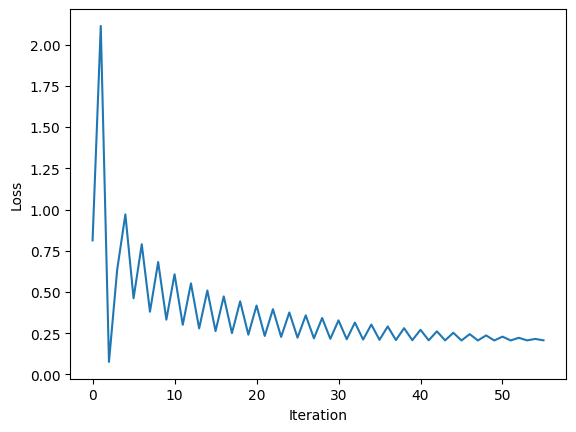

Iter 0060 | Total Loss 0.196943


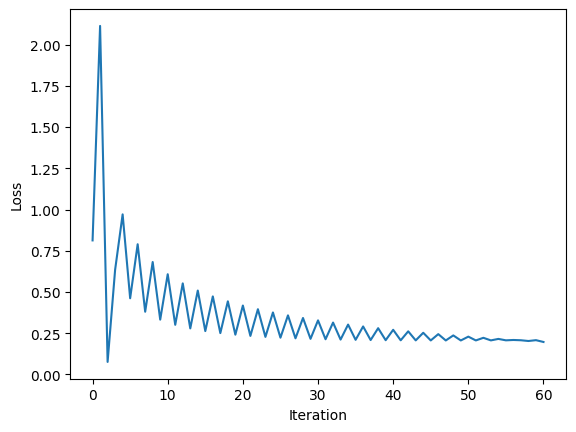

Iter 0065 | Total Loss 0.209845


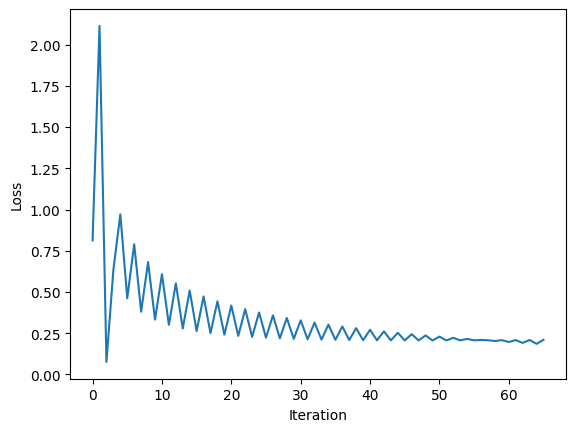

Iter 0070 | Total Loss 0.170428


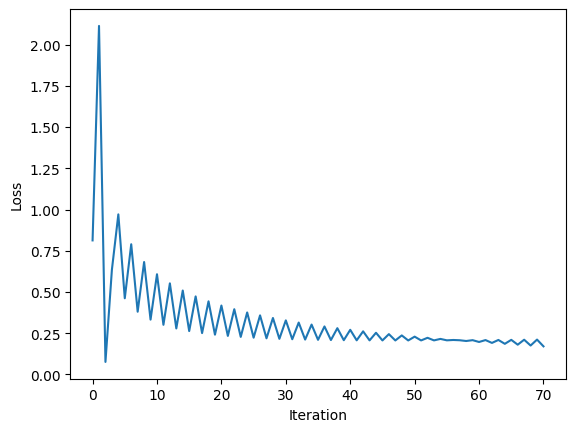

Iter 0075 | Total Loss 0.214091


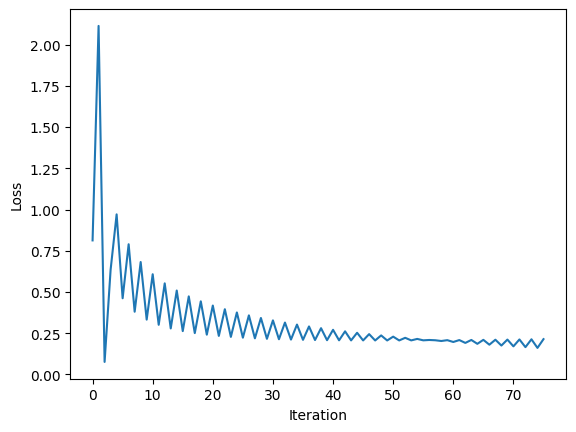

Iter 0080 | Total Loss 0.147917


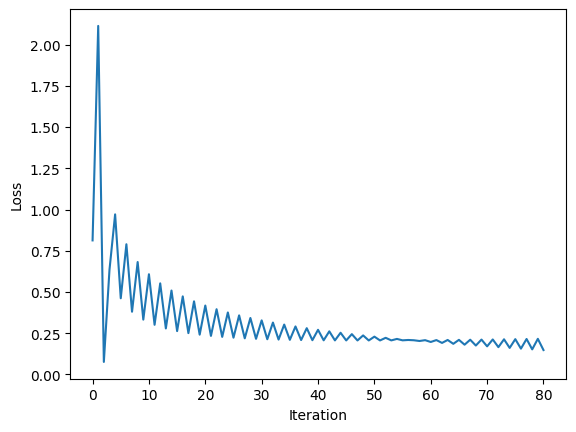

Iter 0085 | Total Loss 0.219152


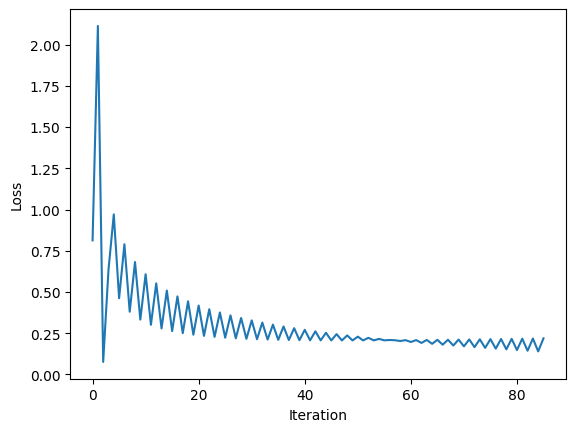

Iter 0090 | Total Loss 0.128303


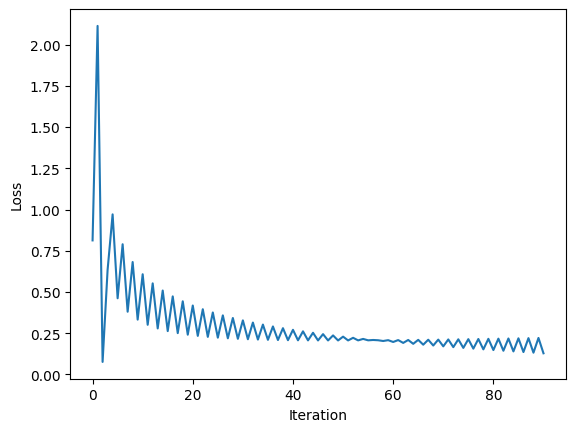

Iter 0095 | Total Loss 0.224738


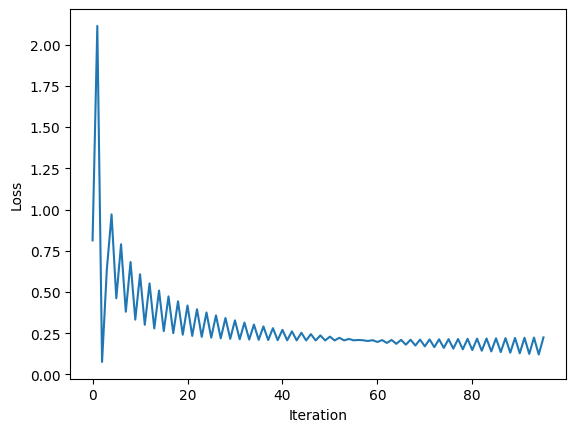

In [17]:

"""Train neural ode with 1 fixed input:"""

losses = []
for itr in range(100):
    optimizer.zero_grad()
    p1, p2, p3 = model(input)
    loss = torch.mean(torch.abs(p1 - tl1) + torch.abs(p2 - tl2) + torch.abs(p3 - tl3))
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if itr % 5 == 0:
      print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

      #if itr % 50 == 0:
      plt.plot(np.arange(len(losses)), losses)
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.show()


Create NN-interpolator based model, and train both models on fixed input:

Parameter fc1.weight is on device: cpu
Parameter fc1.bias is on device: cpu
Parameter fc2.weight is on device: cpu
Parameter fc2.bias is on device: cpu
Parameter fc1.weight is on device: cpu
Parameter fc1.bias is on device: cpu
Parameter fc2.weight is on device: cpu
Parameter fc2.bias is on device: cpu


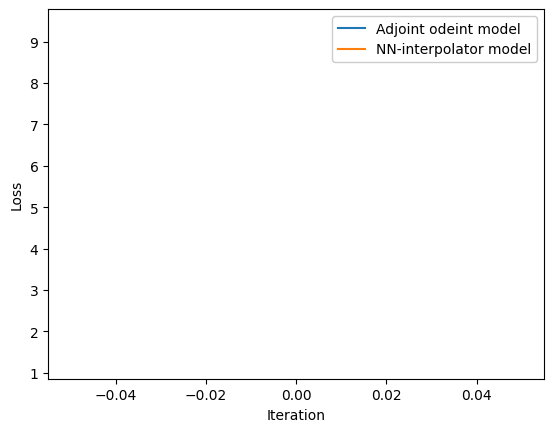

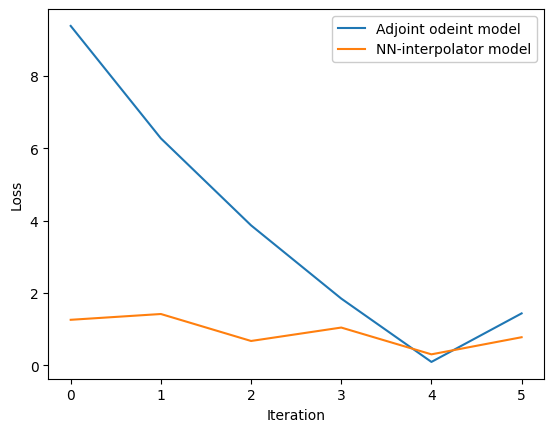

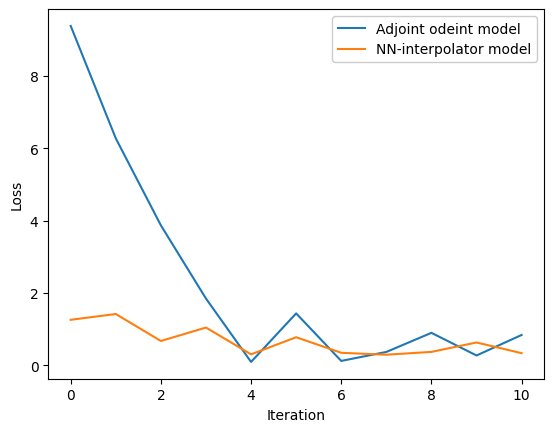

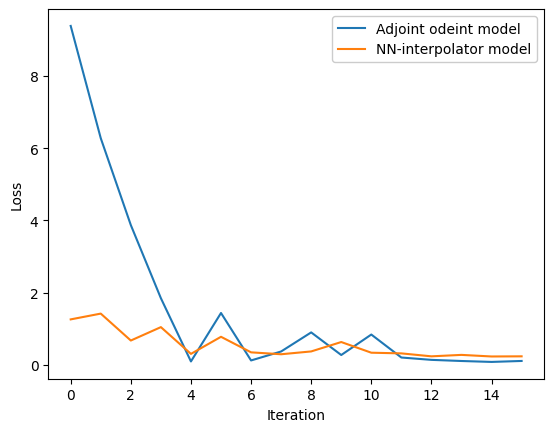

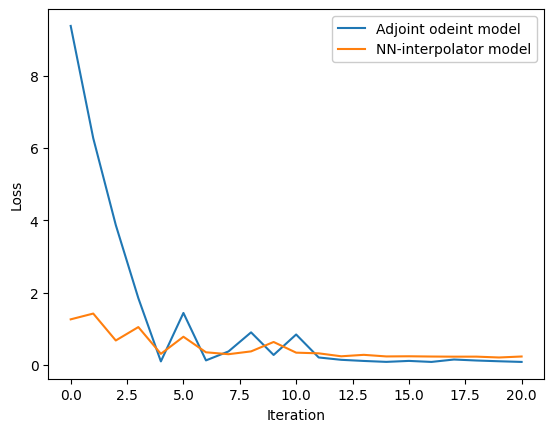

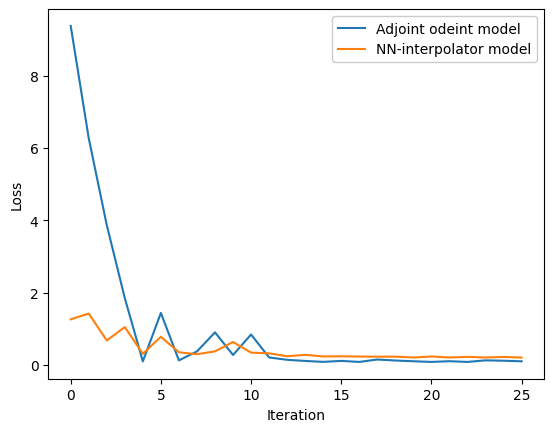

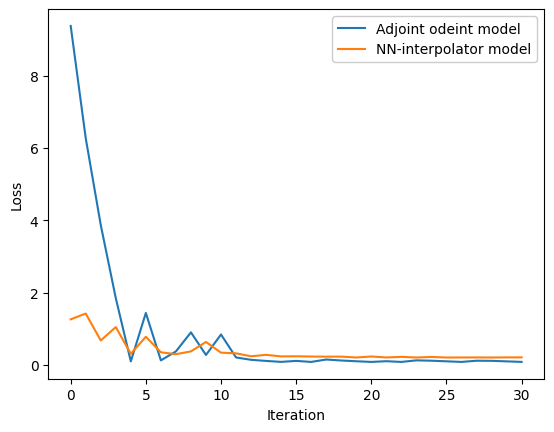

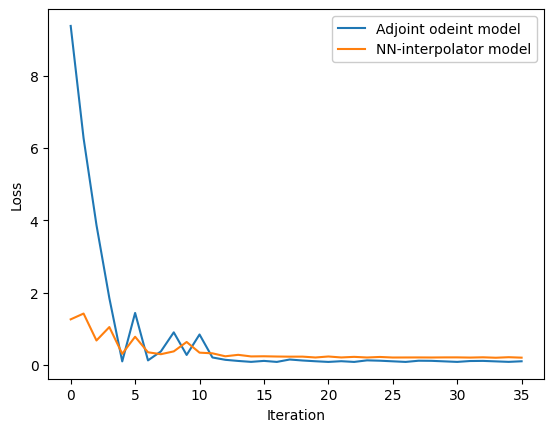

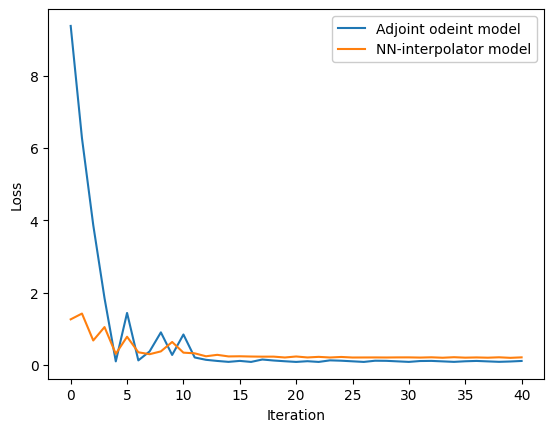

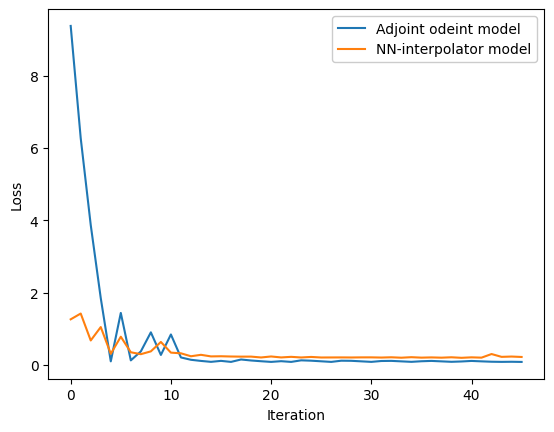

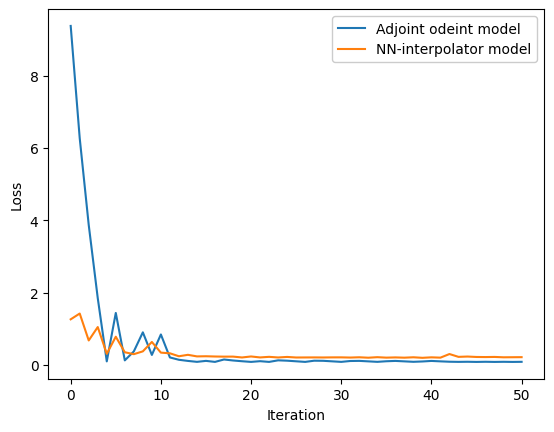

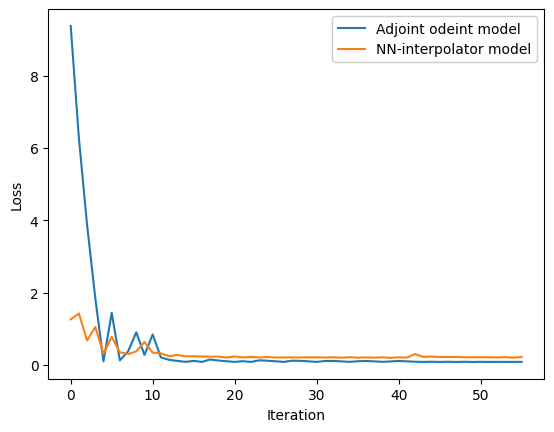

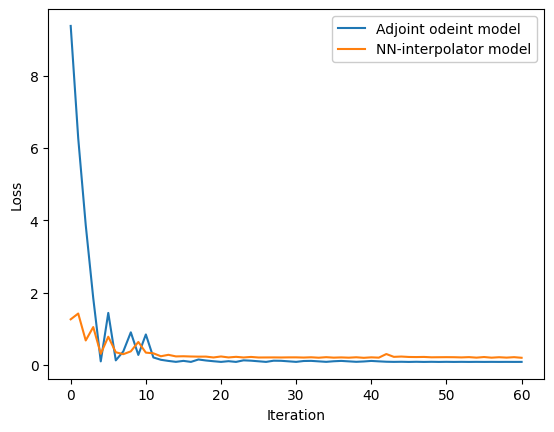

KeyboardInterrupt: 

In [18]:

""" NN interpolator-based model: net """

for name, param in net.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

for param in net.parameters(): param.requires_grad = False

class Normalizer1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lower = torch.tensor([ints[0][0], ints[1][0], ints[2][0]], dtype=torch.float32)
        self.upper = torch.tensor([ints[0][1], ints[1][1], ints[2][1]], dtype=torch.float32)
    def forward(self, inputs):
        return torch.sigmoid(inputs) * (self.upper - self.lower) + self.lower

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        ## equivalent to transformations into the transformations video->tensor with the 7 parameters
        self.fc1 = nn.Linear(4, 64).double()
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(64, 3).double()
        self.norm1 = Normalizer1()
        self.interpolator = net

    def forward(self, x):

        ## next two lines would be the transformation 3DCNN: video -> 7 parameters; pars = the 7 parameters normalized
        x = self.relu(self.fc1(x))
        pars = self.norm1(self.fc21(x)) #pars: (Tc, startv, emax, emin, rm, ra)
        e1, e2, e3 = self.interpolator(pars)
        return e1, e2, e3

"""Train both models on same fixed input:"""

model1 = NeuralODE()
model2 = Model2()
optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-3)
optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-3)
losses1 = []
losses2 = []

for name, param in model1.named_parameters():
    print(f"Parameter {name} is on device: {param.device}")

for itr in range(150):
    #model1:
    optimizer1.zero_grad()
    p1, p2, p3 = model1(input)
    loss = torch.mean(torch.abs(p1 - tl1) + torch.abs(p2 - tl2) + torch.abs(p3 - tl3))
    loss.backward()
    optimizer1.step()
    losses1.append(loss.item())

    #model2:
    optimizer2.zero_grad()
    p1, p2, p3 = model2(input)
    loss2 = torch.mean(torch.abs(p1 - tl1) + torch.abs(p2 - tl2) + torch.abs(p3 - tl3))
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    if itr == 10: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-4)
    if itr == 10: optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-4)
    if itr == 40: optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-5)
    if itr == 40: optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-4)

    if itr % 5 == 0:
      #print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss1.item()))
      plt.plot(np.arange(len(losses1)), losses1, label='Adjoint odeint model')
      plt.plot(np.arange(len(losses2)), losses2, label='NN-interpolator model')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()


Train both models on a synthetic dataset of 400 patients (and 50 for testing).
Create synthetic dataset:

In [19]:
n_patients = 450
inputs = torch.zeros(n_patients, 4)
labels = torch.zeros(n_patients, 3)

for i in range(450):
  a0, b0, c0 = random.uniform(ints[0][0], ints[0][1]), random.uniform(ints[1][0], ints[1][1]), random.uniform(ints[2][0], ints[2][1])
  X, l1, l2, l3 = get_input_and_l(a0, b0, c0, t1, t2, t3)
  inputs[i][0], inputs[i][1], inputs[i][2], inputs[i][3] = X[0], X[1], X[2], X[3]
  labels[i][0], labels[i][1], labels[i][2] = l1, l2, l3

inputs_dt, labels_dt = inputs, labels

Using the data, train both models:

<ipython-input-20-c3ca840ad639>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype = torch.float64)
<ipython-input-20-c3ca840ad639>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype = torch.float64)


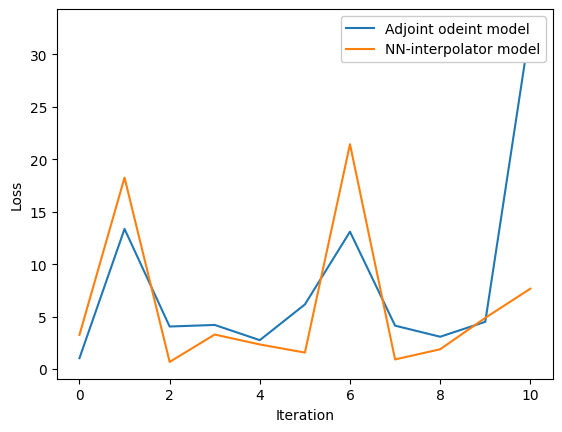

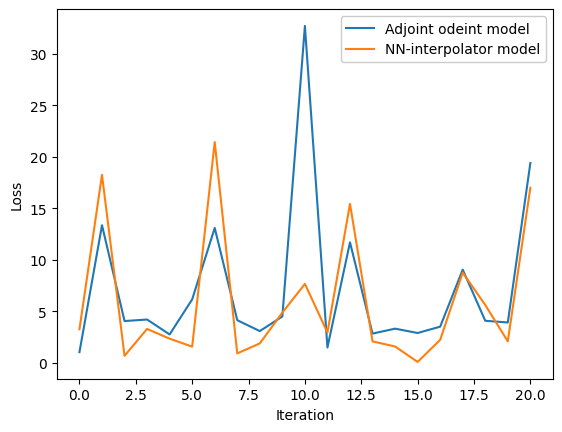

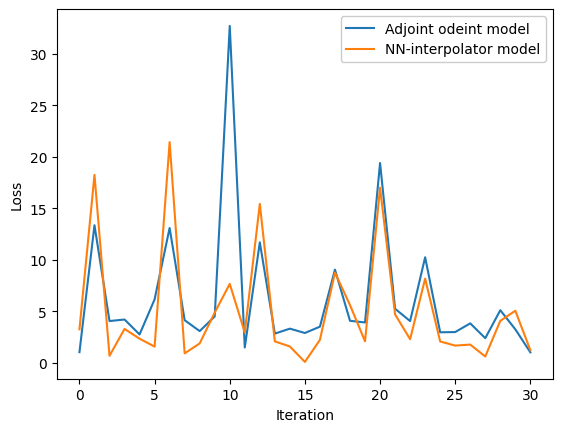

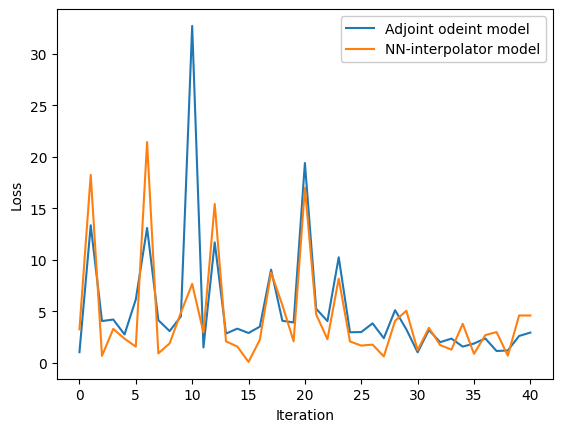

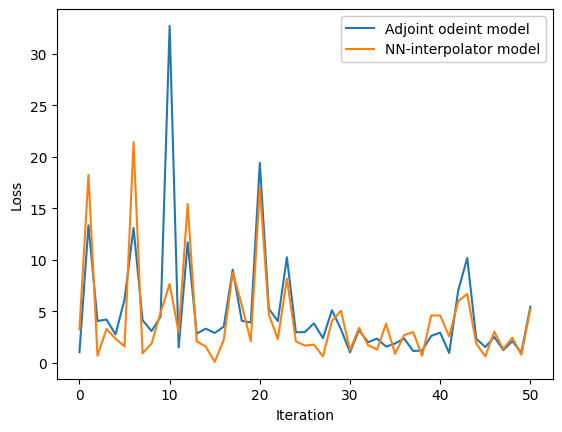

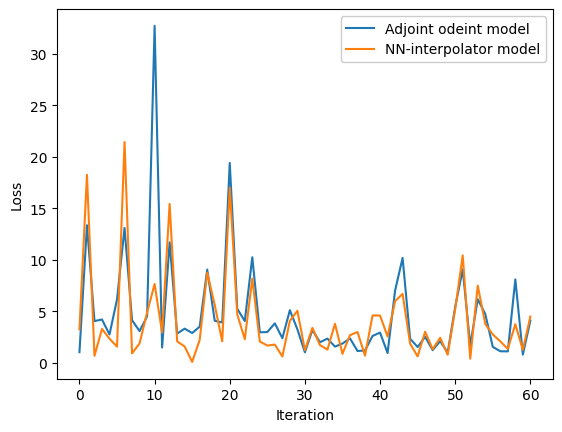

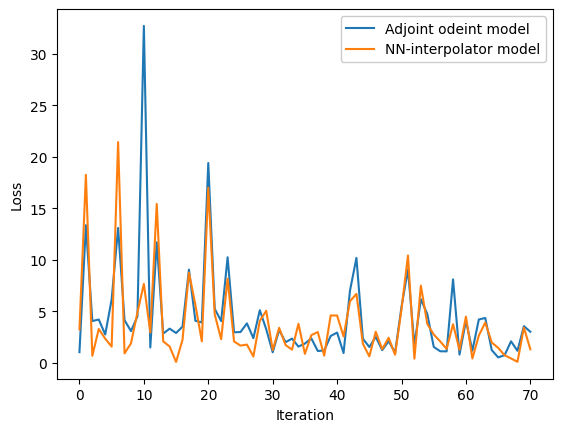

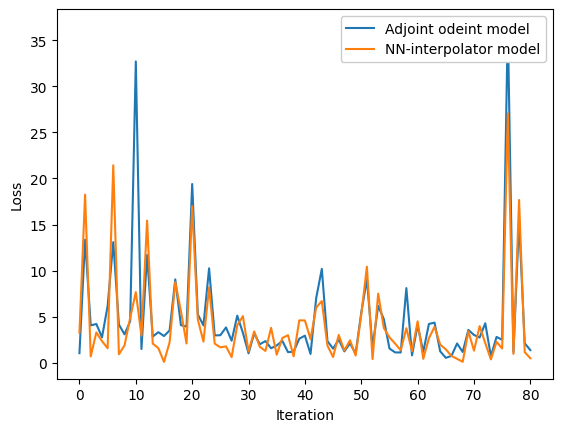

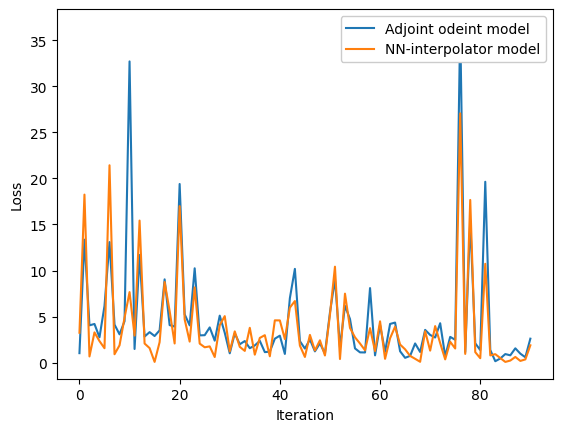

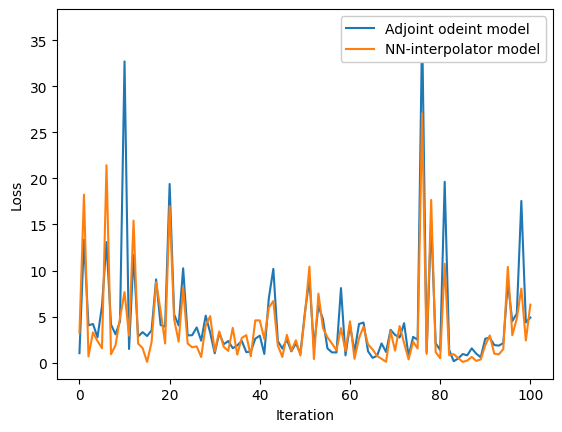

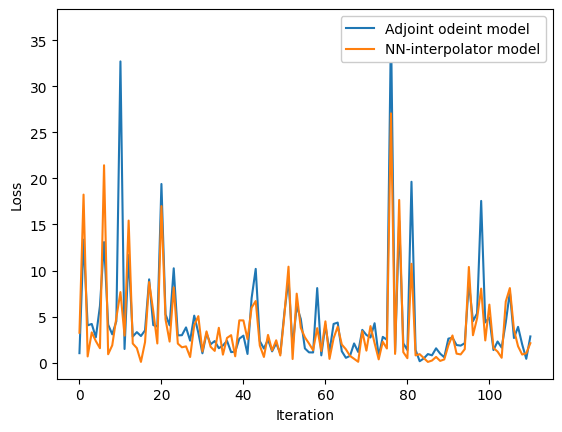

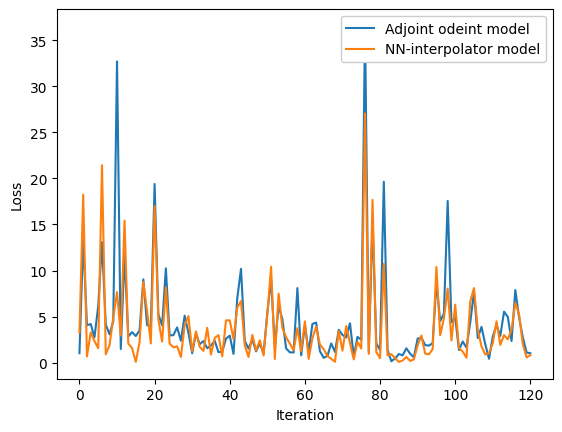

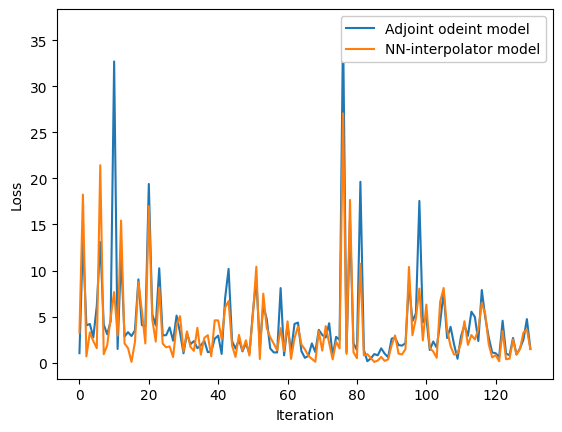

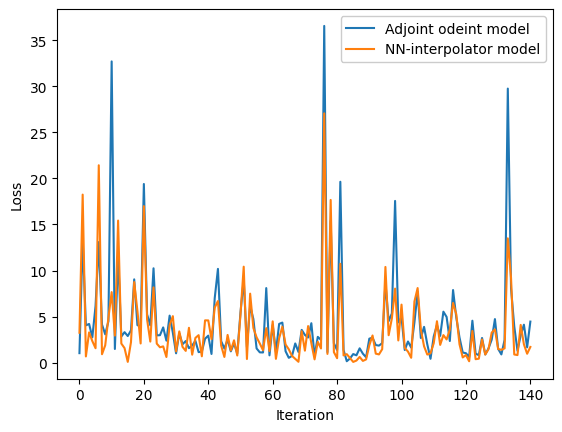

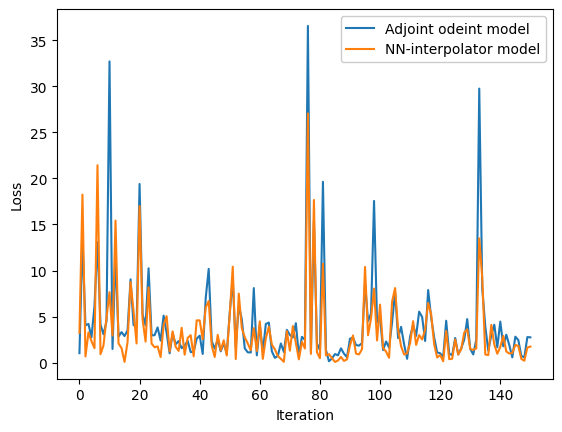

KeyboardInterrupt: 

In [20]:
ntrain = 400 # size of training dataset
ntest = 20 # 50: too much time
model1 = NeuralODE()
model2 = Model2()
optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-3)
optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-3)
losses1 = []
losses2 = []

x_train = torch.zeros((ntrain, 4))
y_train = torch.zeros((ntrain, 3))
for i in range(ntrain):
  x_train[i][0], x_train[i][1], x_train[i][2], x_train[i][3] = inputs[i][0], inputs[i][1], inputs[i][2], inputs[i][3]
  y_train[i][0], y_train[i][1], y_train[i][2] = labels[i][0], labels[i][1], labels[i][2]
x_train = torch.tensor(x_train, dtype = torch.float64)
y_train = torch.tensor(y_train, dtype = torch.float64)

n_epochs = 100
n_itrs = ntrain * n_epochs

for itr in range(n_itrs):
    j = itr % ntrain
    optimizer1.zero_grad()
    e1, e2, e3 = model1(x_train[j])
    #loss1 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    loss1 = torch.abs(e1 - y_train[j][0]) + torch.abs(e2 - y_train[j][1]) + torch.abs(e3 - y_train[j][2])
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())

    optimizer2.zero_grad()
    #loss2 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
    e1, e2, e3 = model2(x_train[j])
    loss2 = torch.abs(e1 - y_train[j][0]) + torch.abs(e2 - y_train[j][1]) + torch.abs(e3 - y_train[j][2])
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

    if itr == 30:
      optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-4)
      optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-4)

    if itr == 60:
      optimizer1 = optim.RMSprop(model1.parameters(), lr=1e-4)
      optimizer2 = optim.RMSprop(model2.parameters(), lr=1e-4)

    if itr % 10 == 0 and itr>0:
      #print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss1.item()))
      plt.plot(np.arange(len(losses1)), losses1, label='Adjoint odeint model')
      plt.plot(np.arange(len(losses2)), losses2, label='NN-interpolator model')
      plt.xlabel("Iteration")
      plt.ylabel("Loss")
      plt.legend(loc='upper right', framealpha=1)
      plt.show()

print(itr)

<ipython-input-21-ebb7717d2b00>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_train, dtype = torch.float64)
<ipython-input-21-ebb7717d2b00>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_train, dtype = torch.float64)


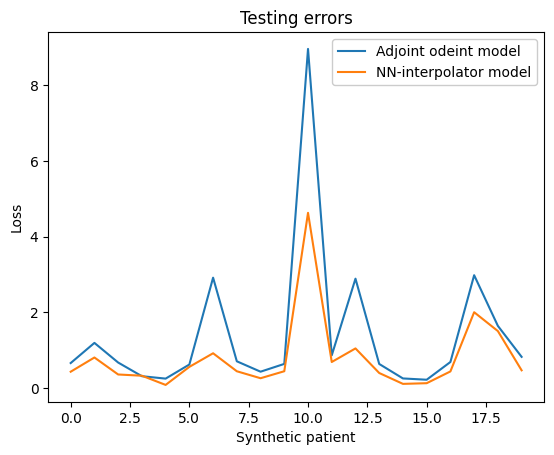

Model1 tensor(1.4228, dtype=torch.float64) Model2 tensor(0.8078, dtype=torch.float64)


In [21]:
## test it:
mae1, mae2 = 0, 0
x_test = torch.zeros((ntest, 4))
y_test = torch.zeros((ntest, 3))
for i in range(ntest):
  x_test[i][0], x_test[i][1], x_test[i][2], x_test[i][3] = inputs[i+ntrain][0], inputs[i+ntrain][1], inputs[i+ntrain][2], inputs[i+ntrain][3]
  y_test[i][0], y_test[i][1], y_test[i][2] = labels[i+ntrain][0], labels[i+ntrain][1], labels[i+ntrain][2]
x_test = torch.tensor(x_train, dtype = torch.float64)
y_test = torch.tensor(y_train, dtype = torch.float64)
tlosses1 = []
tlosses2 = []

with torch.no_grad():
  for j in range(ntest):
      e1, e2, e3 = model1(x_test[j])
      #loss1 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
      loss1 = (torch.abs(e1 - y_test[j][0]) + torch.abs(e2 - y_test[j][1]) + torch.abs(e3 - y_test[j][2]))/3
      tlosses1.append(loss1.item())
      mae1 += loss1

      optimizer2.zero_grad()
      #loss2 = torch.mean(torch.abs(pred_ved - true_ved) + torch.abs(pred_ves - true_ves) + torch.abs(pred_ef - true_ef))
      e1, e2, e3 = model2(x_test[j])
      loss2 = (torch.abs(e1 - y_test[j][0]) + torch.abs(e2 - y_test[j][1]) + torch.abs(e3 - y_test[j][2]))/3
      tlosses2.append(loss2.item())
      mae2 += loss2

plt.title("Testing errors")
plt.plot(np.arange(len(tlosses1)), tlosses1, label='Adjoint odeint model')
plt.plot(np.arange(len(tlosses2)), tlosses2, label='NN-interpolator model')
plt.xlabel("Synthetic patient")
plt.ylabel("Loss")
plt.legend(loc='upper right', framealpha=1)
plt.show()

print("Model1", mae1/ntest, "Model2", mae2/ntest)